In [1]:
!pip install pytorch-crf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchcrf import CRF
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

In [5]:
class MixedTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        boundary_idx = int(self.labels[idx])
        words = text.split()
        if len(words) > self.max_len - 2:
            if boundary_idx > self.max_len - 2:
                words = words[-(self.max_len - 2):]
                boundary_idx = 0
            else:
                words = words[:self.max_len - 2]
        word_labels = [0 if i <= boundary_idx else 1 for i in range(len(words))]
        truncated_text = " ".join(words)
        encoding = self.tokenizer(
            truncated_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
            return_special_tokens_mask=True
        )
        special_tokens_mask = encoding['special_tokens_mask'][0]
        token_labels = []
        current_word_idx = 0

        for is_special in special_tokens_mask:
            if is_special:
                token_labels.append(-100)
            else:
                if current_word_idx < len(word_labels):
                    token_labels.append(word_labels[current_word_idx])
                    current_word_idx += 1
                else:
                    token_labels.append(-100)
        token_labels = token_labels[:self.max_len]
        if len(token_labels) < self.max_len:
            token_labels.extend([-100] * (self.max_len - len(token_labels)))
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(token_labels)
        }

In [6]:
import torch
import torch.nn as nn
import torchcrf
from transformers import AutoModel

class TransformerBiLSTMCRF(nn.Module):
    def __init__(self, transformer_model, hidden_dim, num_labels):
        super(TransformerBiLSTMCRF, self).__init__()
        self.num_labels = num_labels
        self.transformer = AutoModel.from_pretrained(transformer_model)
        self.lstm = nn.LSTM(input_size=self.transformer.config.hidden_size, hidden_size=hidden_dim, num_layers=3, bidirectional=True, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        self.activation = nn.ReLU()
        self.crf = torchcrf.CRF(num_labels, batch_first=True)
        nn.init.xavier_uniform_(self.fc.weight)
        if self.fc.bias is not None:
            nn.init.zeros_(self.fc.bias)

    def forward(self, input_ids, attention_mask, labels=None):
        transformer_outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = transformer_outputs.last_hidden_state
        lstm_out, _ = self.lstm(sequence_output)
        emissions = self.fc(self.activation(lstm_out))
        if labels is not None:
          mask = attention_mask.bool()
          crf_labels = labels.clone()
          crf_labels[crf_labels == -100] = 0
          log_likelihood = self.crf(emissions, crf_labels, mask=mask, reduction='mean')
          return -log_likelihood
        else:
            predictions = self.crf.decode(emissions, mask=attention_mask.bool())
            return predictions


In [7]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

def compute_metrics(predictions, labels):
    predictions = np.array(predictions)
    labels = np.array(labels)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average="weighted", zero_division=0)
    recall = recall_score(labels, predictions, average="weighted", zero_division=0)
    f1 = f1_score(labels, predictions, average="weighted", zero_division=0)
    mcc = matthews_corrcoef(labels, predictions)
    return accuracy, precision, recall, f1, mcc

def train_model(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        loss = model(input_ids, attention_mask, labels)  # Compute loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            predictions = model(input_ids, attention_mask)
            for pred_seq, label_seq, mask_seq in zip(predictions, labels, attention_mask):
                pred_seq = torch.tensor(pred_seq, device=device)
                if len(pred_seq) < mask_seq.size(0):
                    padding = torch.zeros(mask_seq.size(0) - len(pred_seq), device=device)
                    pred_seq = torch.cat([pred_seq, padding])
                mask_seq = mask_seq.to(device)
                label_seq = label_seq.to(device)
                valid_indices = (mask_seq == 1) & (label_seq != -100)
                valid_pred = pred_seq[valid_indices].cpu().numpy()
                valid_label = label_seq[valid_indices].cpu().numpy()
                all_predictions.extend(valid_pred)
                all_labels.extend(valid_label)

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average="weighted", zero_division=0)
    recall = recall_score(all_labels, all_predictions, average="weighted", zero_division=0)
    f1 = f1_score(all_labels, all_predictions, average="weighted", zero_division=0)
    mcc = matthews_corrcoef(all_labels, all_predictions)

    mae = np.mean(np.abs(all_predictions - all_labels))
    std_dev = np.std(all_predictions - all_labels)

    return accuracy, precision, recall, f1, mcc, mae, std_dev

In [8]:
from transformers import AutoTokenizer, get_linear_schedule_with_warmup

MODEL_NAME = 'distilbert-base-uncased'
HIDDEN_DIM = 256

def setup_training(train_texts, train_labels, dev_texts, dev_labels, model_name=MODEL_NAME, batch_size=8, max_len=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    train_dataset = MixedTextDataset(train_texts, train_labels, tokenizer, max_len)
    dev_dataset = MixedTextDataset(dev_texts, dev_labels, tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TransformerBiLSTMCRF(model_name, hidden_dim=HIDDEN_DIM, num_labels=2)
    model.to(device)

    optimizer_grouped_parameters = [
        {"params": model.transformer.embeddings.parameters(), "lr": 1e-6},
        # {"params": model.transformer.encoder.layer[:6].parameters(), "lr": 5e-6},
        # {"params": model.transformer.encoder.layer[6:].parameters(), "lr": 1e-5},
        {"params": model.lstm.parameters(), "lr": 1e-4},
        {"params": model.fc.parameters(), "lr": 1e-4},
        {"params": model.crf.parameters(), "lr": 1e-4},
    ]
    optimizer_grouped_parameters.append(
        {"params": [param for name, param in model.transformer.named_parameters() if 'embeddings' not in name], "lr": 1e-5}
    )
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=5e-6, weight_decay=0.01)

    num_training_steps = len(train_loader) * 3
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * num_training_steps, num_training_steps=num_training_steps)

    return model, train_loader, dev_loader, optimizer, scheduler, device


In [9]:
train_df = pd.read_csv('/content/drive/MyDrive/SCI AIGC/sentence_train_data.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/SCI AIGC/sentence_dev_data.csv')

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()
dev_texts = dev_df["text"].tolist()
dev_labels = dev_df["label"].tolist()

model, train_loader, dev_loader, optimizer, scheduler, device = setup_training(train_texts, train_labels, dev_texts, dev_labels, MODEL_NAME)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [10]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
dataset = MixedTextDataset([train_texts[0]], [train_labels[0]], tokenizer, max_len=512)
sample = dataset[0]
print(f"Input sequence length: {len(sample['input_ids'])}")
print(f"Label sequence length: {len(sample['labels'])}")

Input sequence length: 512
Label sequence length: 512


In [11]:
import torch

def extract_lstm_features(model, sentences, tokenizer, max_len=512, device='cpu'):
    model.eval()
    features = []

    for sentence in sentences:
        encoding = tokenizer(
            sentence,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            transformer_outputs = model.transformer(input_ids=input_ids, attention_mask=attention_mask)
            sequence_output = transformer_outputs.last_hidden_state
            lstm_output, _ = model.lstm(sequence_output)
            lstm_features = lstm_output.mean(dim=1).cpu().numpy()
            features.append(lstm_features)

    return np.vstack(features)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

TransformerBiLSTMCRF(
  (transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (l

In [13]:
df = pd.read_csv('/content/train_dev_test_M4GT.csv')
df

,text,label,split
0,- Strengths:\n* Outperforms ALIGN in supervise...,88,train
1,This paper addresses the problem of disambigua...,286,train
2,"- Strengths:\nGood ideas, simple neural learni...",62,train
3,This paper presents several weakly supervised ...,35,train
4,This paper describes a model for cross-lingual...,98,train
...,...,...,...
30645,The framework of Gatys et al. demonstrated tha...,42,test
30646,The paper develops a simple and reasonable alg...,39,test
30647,The authors proposed to learn embeddings of us...,9,test
30648,The paper presents an alternative way of super...,40,test


In [14]:
df.columns

Index(['text', 'label', 'split'], dtype='object')

In [15]:
def split_text_by_word_count(row):
    words = row['text'].split()
    human_words = words[:row['label']]
    machine_words = words[row['label']:]
    return ' '.join(human_words), ' '.join(machine_words)

In [16]:
df['human_text'], df['machine_text'] = zip(*df.apply(split_text_by_word_count, axis=1))
df

,text,label,split,human_text,machine_text
0,- Strengths:\n* Outperforms ALIGN in supervise...,88,train,- Strengths: * Outperforms ALIGN in supervised...,clear to me whether N(e_j) includes only entit...
1,This paper addresses the problem of disambigua...,286,train,This paper addresses the problem of disambigua...,in a relatedness graph. This means that for ea...
2,"- Strengths:\nGood ideas, simple neural learni...",62,train,"- Strengths: Good ideas, simple neural learnin...",procedure connected with the modeling allows t...
3,This paper presents several weakly supervised ...,35,train,This paper presents several weakly supervised ...,improvements of existing techniques in weakly ...
4,This paper describes a model for cross-lingual...,98,train,This paper describes a model for cross-lingual...,behind proposing a Continuous Bag-of-word (CBO...
...,...,...,...,...,...
30645,The framework of Gatys et al. demonstrated tha...,42,test,The framework of Gatys et al. demonstrated tha...,"However, I think there are some limitations in..."
30646,The paper develops a simple and reasonable alg...,39,test,The paper develops a simple and reasonable alg...,"state-of-the-art baselines, providing strong e..."
30647,The authors proposed to learn embeddings of us...,9,test,The authors proposed to learn embeddings of us...,using two separate neural network encoders (du...
30648,The paper presents an alternative way of super...,40,test,The paper presents an alternative way of super...,of the other. The proposed method can be seen ...


In [17]:
df['text'].iloc[0]

"- Strengths:\n* Outperforms ALIGN in supervised entity linking task which suggests that the\nproposed framework improves representations of text and knowledge that are\nlearned jointly.\n* Direct comparison with closely related approach using very similar input\ndata.\n* Analysis of the smoothing parameter provides useful analysis since impact of\npopularity is a persistent issue in entity linking.\n\n- Weaknesses:\n* Comparison with ALIGN could be better. ALIGN used content window size 10 vs\nthis paper's 5, vector dimension of 500 vs this paper's 200. Also its not clear\nto me whether N(e_j) includes only entities that link to the mention or also includes other related entities. This could be further clarified in the paper. Additionally, the experimental results could be strengthened by including comparisons with other state-of-the-art models and datasets. While the proposed framework shows promising results in entity linking, it would be informative to see how it performs in other 

In [18]:
df['human_text'].iloc[0]

"- Strengths: * Outperforms ALIGN in supervised entity linking task which suggests that the proposed framework improves representations of text and knowledge that are learned jointly. * Direct comparison with closely related approach using very similar input data. * Analysis of the smoothing parameter provides useful analysis since impact of popularity is a persistent issue in entity linking. - Weaknesses: * Comparison with ALIGN could be better. ALIGN used content window size 10 vs this paper's 5, vector dimension of 500 vs this paper's 200. Also its not"

In [19]:
df['machine_text'].iloc[0]

'clear to me whether N(e_j) includes only entities that link to the mention or also includes other related entities. This could be further clarified in the paper. Additionally, the experimental results could be strengthened by including comparisons with other state-of-the-art models and datasets. While the proposed framework shows promising results in entity linking, it would be informative to see how it performs in other text and knowledge integration tasks. Overall, the paper presents an interesting approach to address the ambiguity in entity mentions by learning multi-prototype mention embeddings. The proposed disambiguation method and embedding models show high quality performance, leading to state-of-the-art results in entity linking. With some minor improvements and further analysis, this work has the potential to make a significant contribution to the field of text and knowledge integration.'

In [20]:
df

,text,label,split,human_text,machine_text
0,- Strengths:\n* Outperforms ALIGN in supervise...,88,train,- Strengths: * Outperforms ALIGN in supervised...,clear to me whether N(e_j) includes only entit...
1,This paper addresses the problem of disambigua...,286,train,This paper addresses the problem of disambigua...,in a relatedness graph. This means that for ea...
2,"- Strengths:\nGood ideas, simple neural learni...",62,train,"- Strengths: Good ideas, simple neural learnin...",procedure connected with the modeling allows t...
3,This paper presents several weakly supervised ...,35,train,This paper presents several weakly supervised ...,improvements of existing techniques in weakly ...
4,This paper describes a model for cross-lingual...,98,train,This paper describes a model for cross-lingual...,behind proposing a Continuous Bag-of-word (CBO...
...,...,...,...,...,...
30645,The framework of Gatys et al. demonstrated tha...,42,test,The framework of Gatys et al. demonstrated tha...,"However, I think there are some limitations in..."
30646,The paper develops a simple and reasonable alg...,39,test,The paper develops a simple and reasonable alg...,"state-of-the-art baselines, providing strong e..."
30647,The authors proposed to learn embeddings of us...,9,test,The authors proposed to learn embeddings of us...,using two separate neural network encoders (du...
30648,The paper presents an alternative way of super...,40,test,The paper presents an alternative way of super...,of the other. The proposed method can be seen ...


In [22]:
df = df[df['split'] != 'test']
df

,text,label,split,human_text,machine_text
0,- Strengths:\n* Outperforms ALIGN in supervise...,88,train,- Strengths: * Outperforms ALIGN in supervised...,clear to me whether N(e_j) includes only entit...
1,This paper addresses the problem of disambigua...,286,train,This paper addresses the problem of disambigua...,in a relatedness graph. This means that for ea...
2,"- Strengths:\nGood ideas, simple neural learni...",62,train,"- Strengths: Good ideas, simple neural learnin...",procedure connected with the modeling allows t...
3,This paper presents several weakly supervised ...,35,train,This paper presents several weakly supervised ...,improvements of existing techniques in weakly ...
4,This paper describes a model for cross-lingual...,98,train,This paper describes a model for cross-lingual...,behind proposing a Continuous Bag-of-word (CBO...
...,...,...,...,...,...
19522,.The paper addresses the challenge of training...,0,dev,,.The paper addresses the challenge of training...
19523,First I would like to apologize for the delay ...,81,dev,First I would like to apologize for the delay ...,4.1) 2. The The model is trained on the big ar...
19524,This paper proposes a study of transfer learni...,99,dev,This paper proposes a study of transfer learni...,the target domain in order to achieve any mean...
19525,This work investigates the performance of tran...,18,dev,This work investigates the performance of tran...,SQuAD datasets) for reading comprehension task...


In [23]:
human_features = extract_lstm_features(model, df["human_text"], tokenizer, device=device)
machine_features = extract_lstm_features(model, df["machine_text"], tokenizer, device=device)

In [24]:
features = np.vstack((human_features, machine_features))
labels = np.array(["Human"] * len(human_features) + ["Machine"] * len(machine_features))

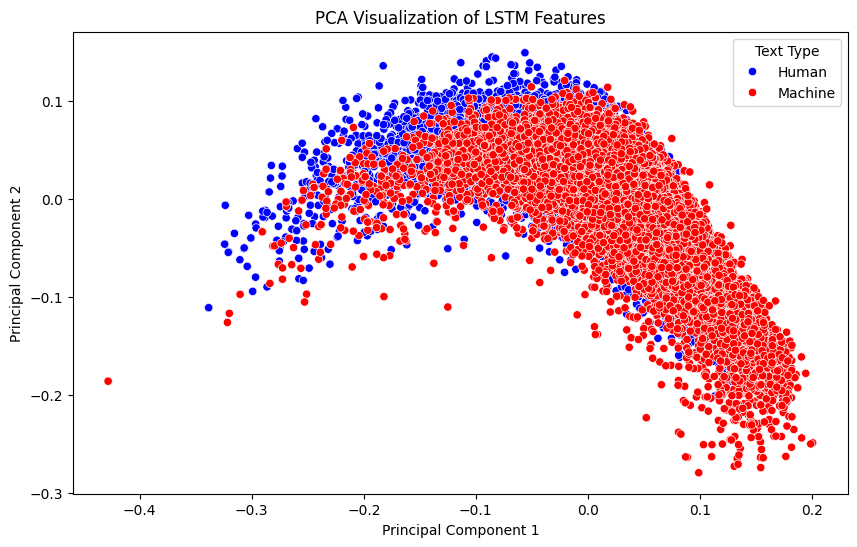

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from umap import UMAP
from scipy.stats import ttest_ind, f_oneway

pca = PCA(n_components=2)
pca_features = pca.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=labels, palette=["blue", "red"])
plt.title("PCA Visualization of LSTM Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Text Type")
plt.show()

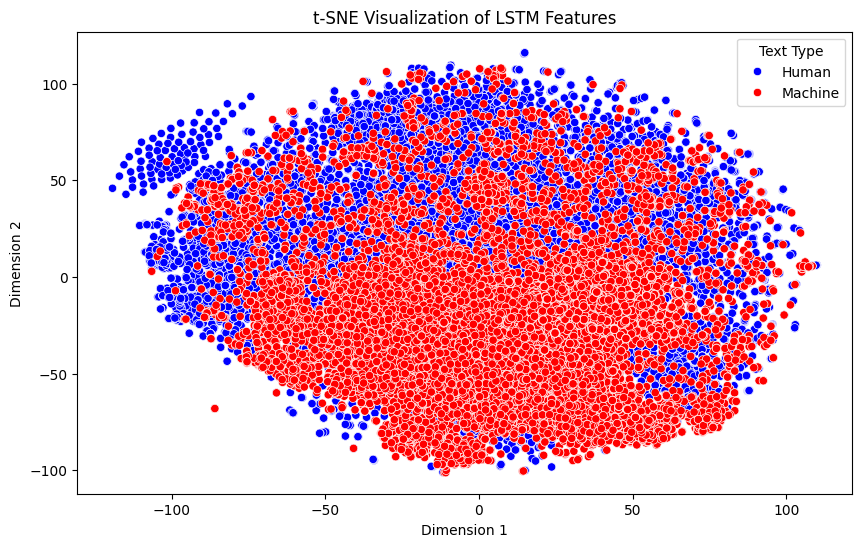

In [28]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_features[:, 0], y=tsne_features[:, 1], hue=labels, palette=["blue", "red"])
plt.title("t-SNE Visualization of LSTM Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Text Type")
plt.show()


In [29]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00


In [30]:
from umap import UMAP

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


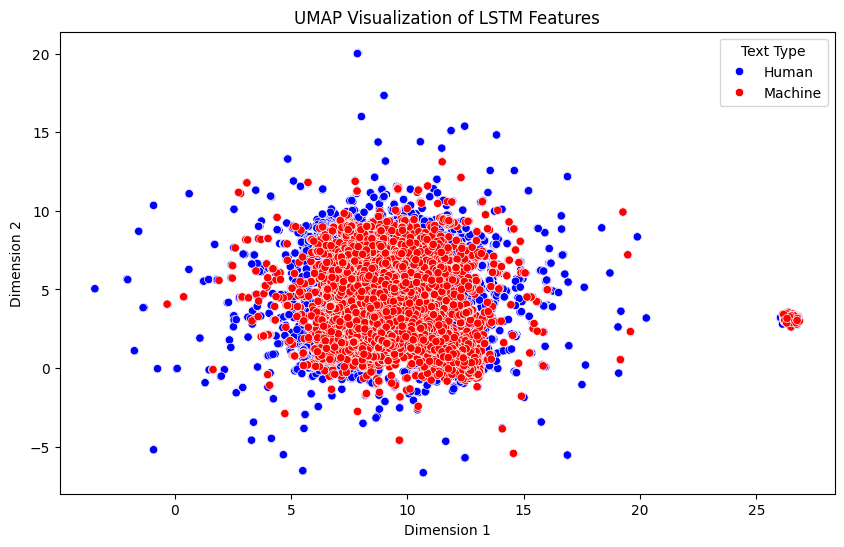

In [31]:
umap = UMAP(n_components=2, random_state=42)
umap_features = umap.fit_transform(features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_features[:, 0], y=umap_features[:, 1], hue=labels, palette=["blue", "red"])
plt.title("UMAP Visualization of LSTM Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend(title="Text Type")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


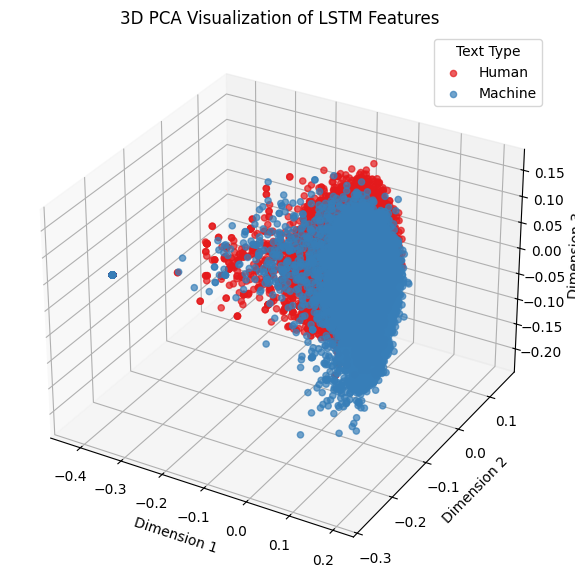

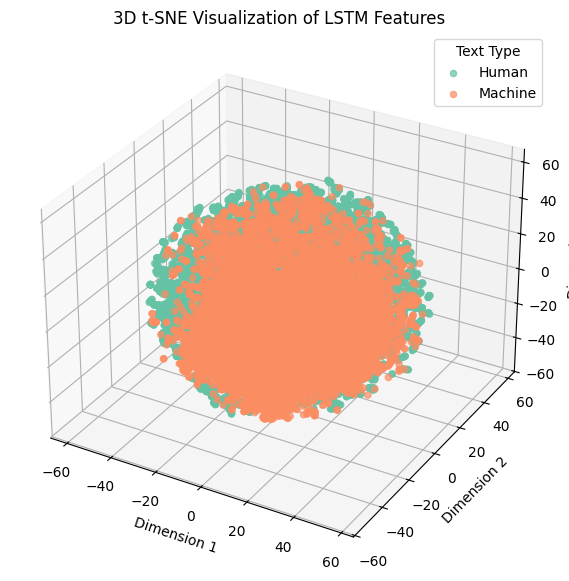

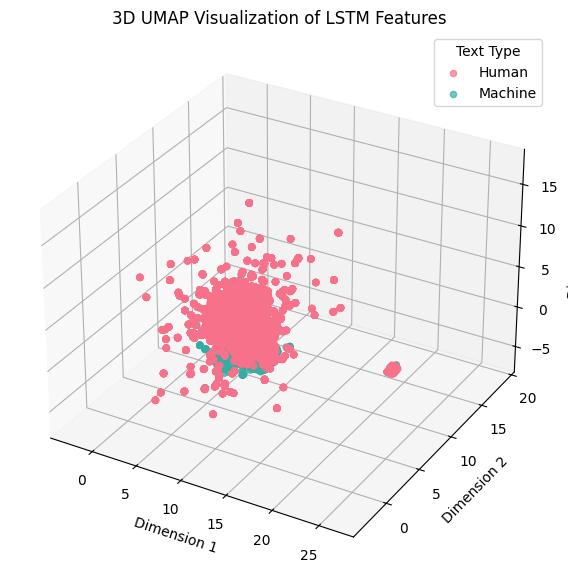

T-Test: t-statistic=4.453, p-value=8.458e-06
ANOVA: F-statistic=19.833, p-value=8.452e-06

Top 5 Dimensions with the Largest T-Statistic:
Dimension 270: t-stat=-108.213, p-value=0.000e+00
Dimension 402: t-stat=103.226, p-value=0.000e+00
Dimension 46: t-stat=102.672, p-value=0.000e+00
Dimension 169: t-stat=-95.040, p-value=0.000e+00
Dimension 461: t-stat=-93.372, p-value=0.000e+00


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind, f_oneway

features = np.vstack((human_features, machine_features))
labels = np.array(["Human"] * len(human_features) + ["Machine"] * len(machine_features))

pca = PCA(n_components=3)
pca_features = pca.fit_transform(features)

tsne = TSNE(n_components=3, random_state=42, perplexity=30)
tsne_features = tsne.fit_transform(features)

umap = UMAP(n_components=3, random_state=42)
umap_features = umap.fit_transform(features)

def plot_3d(features, labels, title, palette):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    colors = sns.color_palette(palette, n_colors=len(set(labels)))
    for label, color in zip(np.unique(labels), colors):
        mask = labels == label
        ax.scatter(features[mask, 0], features[mask, 1], features[mask, 2], label=label, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    ax.legend(title="Text Type")
    plt.show()

plot_3d(pca_features, labels, "3D PCA Visualization of LSTM Features", palette="Set1")

plot_3d(tsne_features, labels, "3D t-SNE Visualization of LSTM Features", palette="Set2")

plot_3d(umap_features, labels, "3D UMAP Visualization of LSTM Features", palette="husl")

human_flat = human_features.flatten()
machine_flat = machine_features.flatten()

t_stat, t_pvalue = ttest_ind(human_flat, machine_flat)
print(f"T-Test: t-statistic={t_stat:.3f}, p-value={t_pvalue:.3e}")

f_stat, f_pvalue = f_oneway(human_flat, machine_flat)
print(f"ANOVA: F-statistic={f_stat:.3f}, p-value={f_pvalue:.3e}")

dimension_stats = []
for dim in range(features.shape[1]):
    t_stat_dim, t_pvalue_dim = ttest_ind(human_features[:, dim], machine_features[:, dim])
    dimension_stats.append((dim, t_stat_dim, t_pvalue_dim))

top_differing_dimensions = sorted(dimension_stats, key=lambda x: abs(x[1]), reverse=True)[:5]
print("\nTop 5 Dimensions with the Largest T-Statistic:")
for dim, t_stat_dim, pvalue_dim in top_differing_dimensions:
    print(f"Dimension {dim}: t-stat={t_stat_dim:.3f}, p-value={pvalue_dim:.3e}")


In [37]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


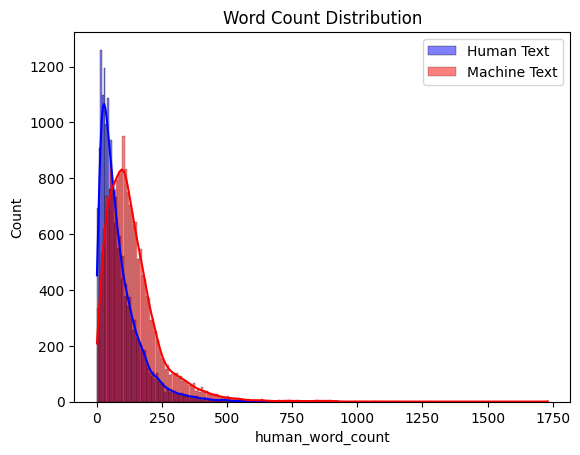

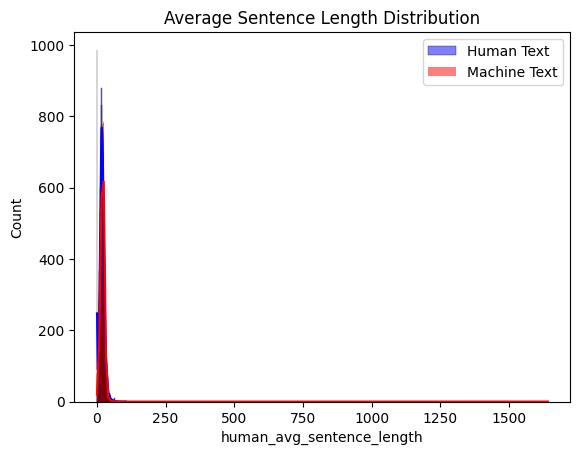

In [38]:
import pandas as pd
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

nlp = spacy.load("en_core_web_sm")

def lexical_features(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)
    word_count = len(words)
    sentence_count = len(sentences)
    if word_count == 0:
        return None, sentence_count, None, None
    avg_word_length = sum(len(word) for word in words) / word_count
    unique_words = set(words)
    ttr = len(unique_words) / word_count
    return word_count, sentence_count, avg_word_length, ttr

df['human_lexical'] = df['human_text'].apply(lexical_features)
df['machine_lexical'] = df['machine_text'].apply(lexical_features)
df = df.dropna(subset=['human_lexical', 'machine_lexical'])
df[['human_word_count', 'human_sentence_count', 'human_avg_word_length', 'human_ttr']] = pd.DataFrame(df['human_lexical'].to_list(), index=df.index)
df[['machine_word_count', 'machine_sentence_count', 'machine_avg_word_length', 'machine_ttr']] = pd.DataFrame(df['machine_lexical'].to_list(), index=df.index)

sns.histplot(df['human_word_count'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_word_count'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.title('Word Count Distribution')
plt.show()

def syntactic_features(text):
    doc = nlp(text)
    sentence_lengths = [len(sent) for sent in doc.sents]
    avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths) if sentence_lengths else 0

    pos_tags = pos_tag(word_tokenize(text))
    pos_counts = Counter(tag for word, tag in pos_tags)
    return avg_sentence_length, pos_counts

df['human_syntactic'] = df['human_text'].apply(syntactic_features)
df['machine_syntactic'] = df['machine_text'].apply(syntactic_features)

df[['human_avg_sentence_length', 'human_pos_counts']] = pd.DataFrame(df['human_syntactic'].to_list(), index=df.index)
df[['machine_avg_sentence_length', 'machine_pos_counts']] = pd.DataFrame(df['machine_syntactic'].to_list(), index=df.index)

sns.histplot(df['human_avg_sentence_length'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_avg_sentence_length'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.title('Average Sentence Length Distribution')
plt.show()


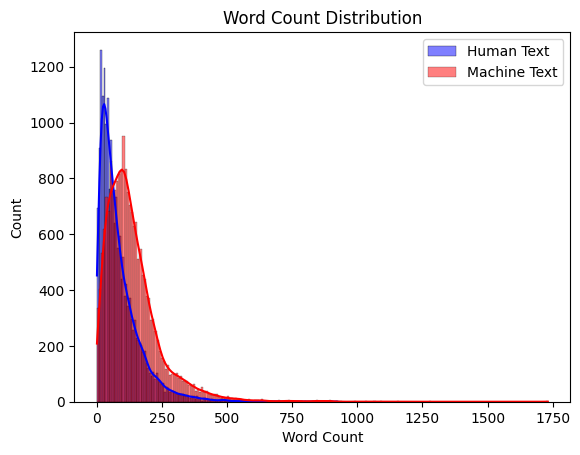

In [49]:
sns.histplot(df['human_word_count'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_word_count'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.xlabel('Word Count')
plt.title('Word Count Distribution')
plt.show()

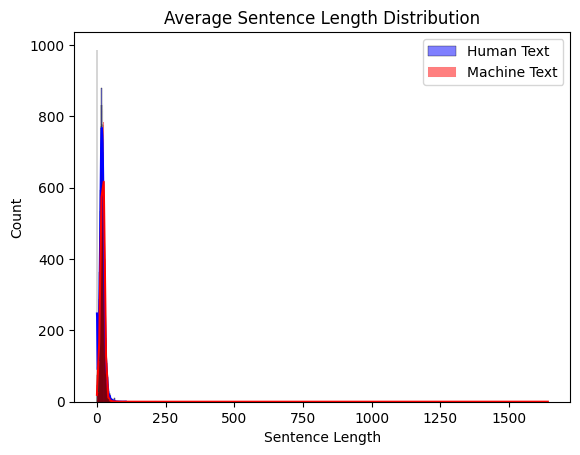

In [48]:
sns.histplot(df['human_avg_sentence_length'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_avg_sentence_length'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.xlabel('Sentence Length')
plt.title('Average Sentence Length Distribution')
plt.show()

In [ ]:
vectorizer = CountVectorizer(stop_words='english')

def semantic_features(human_text, machine_text):
    vectors = vectorizer.fit_transform([human_text, machine_text])
    similarity = cosine_similarity(vectors[0:1], vectors[1:2])
    return similarity[0][0]
df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_text'], row['machine_text']), axis=1)
sns.histplot(df['semantic_similarity'], kde=True)
plt.title('Semantic Similarity Distribution')
plt.show()


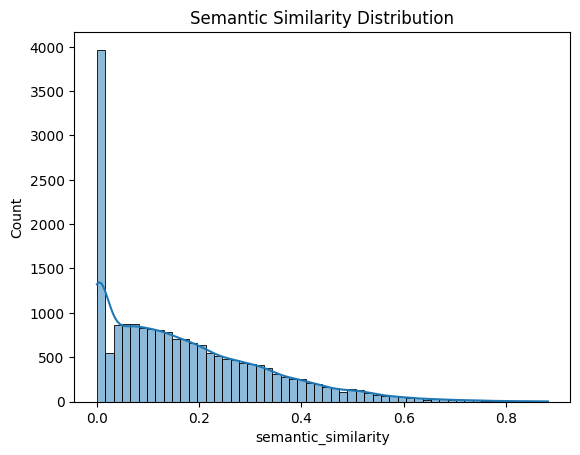

In [41]:
vectorizer = CountVectorizer(stop_words='english')

def semantic_features(human_text, machine_text):
    if not human_text or not machine_text or \
       all(word in vectorizer.get_stop_words() for word in human_text.split()) or \
       all(word in vectorizer.get_stop_words() for word in machine_text.split()):
        return 0.0
    else:
        vectors = vectorizer.fit_transform([human_text, machine_text])
        similarity = cosine_similarity(vectors[0:1], vectors[1:2])
        return similarity[0][0]

df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_text'], row['machine_text']), axis=1)
sns.histplot(df['semantic_similarity'], kde=True)
plt.title('Semantic Similarity Distribution')
plt.show()

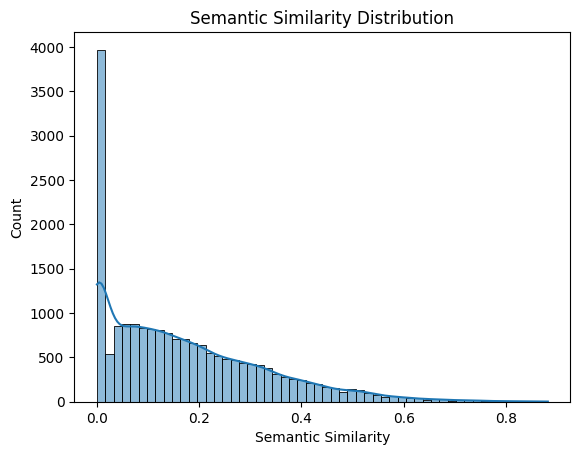

In [47]:
df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_text'], row['machine_text']), axis=1)
sns.histplot(df['semantic_similarity'], kde=True)
plt.xlabel('Semantic Similarity')
plt.title('Semantic Similarity Distribution')
plt.show()

In [43]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

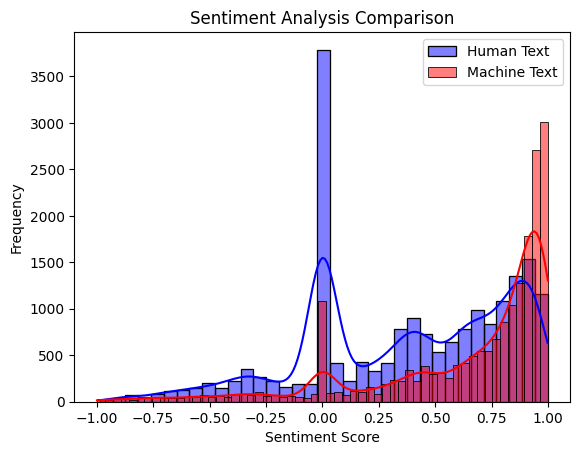

In [46]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

df['human_sentiment'] = df['human_text'].apply(lambda text: sia.polarity_scores(text)['compound'])
df['machine_sentiment'] = df['machine_text'].apply(lambda text: sia.polarity_scores(text)['compound'])

sns.histplot(df['human_sentiment'], color='blue', label='Human Text', kde=True)
sns.histplot(df['machine_sentiment'], color='red', label='Machine Text', kde=True)
plt.legend()
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Analysis Comparison')
plt.show()


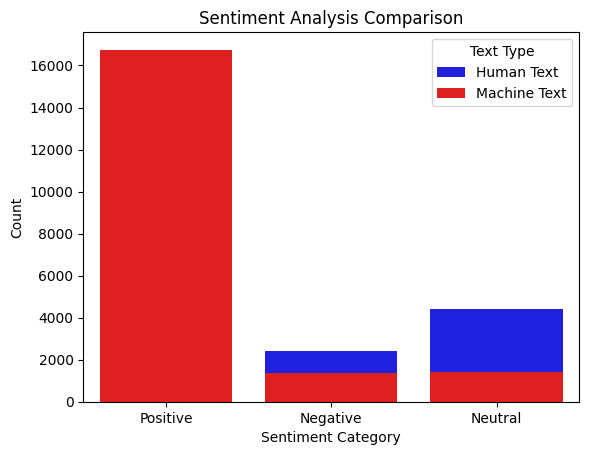

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def sentiment_category(score):
    if score > 0.1:
        return 'Positive'
    elif score < -0.1:
        return 'Negative'
    else:
        return 'Neutral'

df['human_sentiment_category'] = df['human_text'].apply(lambda text: sentiment_category(sia.polarity_scores(text)['compound']))
df['machine_sentiment_category'] = df['machine_text'].apply(lambda text: sentiment_category(sia.polarity_scores(text)['compound']))

sns.countplot(x='human_sentiment_category', data=df, color='blue', label='Human Text')
sns.countplot(x='machine_sentiment_category', data=df, color='red', label='Machine Text')

plt.legend(title='Text Type')
plt.title('Sentiment Analysis Comparison')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()


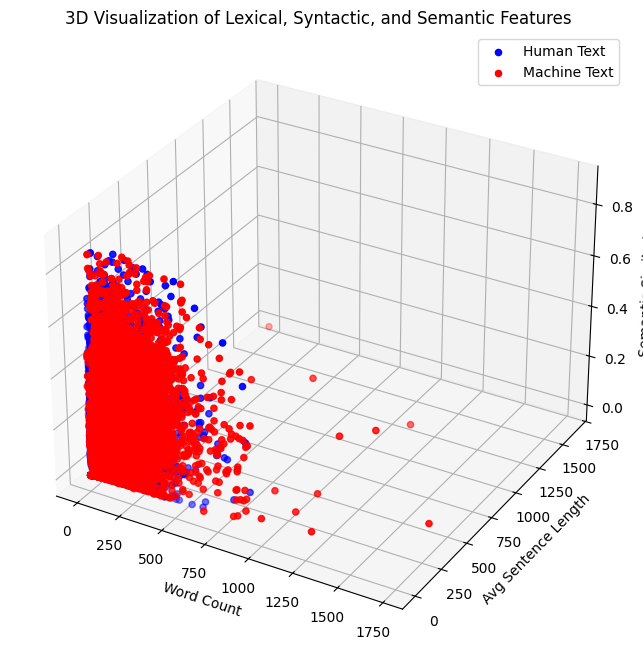

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

df['semantic_similarity'] = df.apply(lambda row: semantic_features(row['human_text'], row['machine_text']), axis=1)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['human_word_count'], df['human_avg_sentence_length'], df['semantic_similarity'], color='blue', label='Human Text')

ax.scatter(df['machine_word_count'], df['machine_avg_sentence_length'], df['semantic_similarity'], color='red', label='Machine Text')

ax.set_xlabel('Word Count')
ax.set_ylabel('Avg Sentence Length')
ax.set_zlabel('Semantic Similarity')
ax.set_title('3D Visualization of Lexical, Syntactic, and Semantic Features')
ax.legend()

plt.show()
